In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import warnings
import math
from numpy import linalg as LA

warnings.filterwarnings('ignore')
%matplotlib inline


In [564]:
#df_data = pd.read_csv('./data/encirclement/DP_LPV_circle.csv')
#df_data = pd.read_csv('./data/encirclement/point_lesion/DP_RPV.csv')  
df_data = pd.read_csv('./data/encirclement/control/CF_RPV.csv')  

In [565]:

# t_nogap is the cut-off where a value above t_nogap means no gap 
def CircularPiePlot(df, t_nogap):
    count = len(df.as_matrix())
    #scalars = df_data_with_theta.as_matrix(columns=df_data_with_theta.columns[7:8])
    scalars = df['MeshScalar'].as_matrix()
    num_prim_groups = 4 #  Do not change as pie plot is hard-coded to accept four primary groups
    num_sub_groups = 4  #  Do not change as pie plot is hard-coded to accept four primary groups
    total_groups = num_prim_groups*num_sub_groups
    sub_group_size = count/total_groups

    # Divide the data into 12 groups, 4 regions x 3 sub-regions, regions = post sup, post inf, etc. 
    sub_group_array = np.zeros(shape=(total_groups, 1))

    n=0
    sb = np.array_split(scalars, total_groups)
    for i in sb: 
        sub_group_array[n] = np.mean(i)
        n += 1
        
    
    # binary classify sub_groups into gaps and no-gaps 
    bin_subgrouparray = sub_group_array > t_nogap
    bin_subgrouparray = bin_subgrouparray * 1    # converts the false true array to 0 1 
    
    # Now prepare data for circular plot 
    
    # First decide color sub-groups based on binary classification of sub_groups (i.e. t_nogaps)
    a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
    color_subgroups = list() 
    for x in bin_subgrouparray: 
        if x == 1:
            color_subgroups.append(b(0.5))
        else:
            color_subgroups.append(c(0.5))
    
    # Decide color of the primary groups (n=4) based on number of sub_groups classified as gaps/no-gaps 
    color_primgroups = list()
    prim_group_array = np.zeros(shape=(num_prim_groups, 1))
        
    # classify primary groups 
    prim_group_array = np.split(bin_subgrouparray, num_prim_groups)
    n=0
    for i in prim_group_array: 
        prim_group_array[n] = np.sum(i)
        n += 1
        
    for x in prim_group_array: 
        if x==1:
            color_primgroups.append('green')
        elif x==2: 
            color_primgroups.append('yellow')
        elif x==3:
            color_primgroups.append('gold')
        elif x==4:
            color_primgroups.append('red')
        else:
            color_primgroups.append('green')   # x == 0
        
        
        
    # Make data: I have 3 groups and 7 subgroups
    group_names=['Post-Sup (A)', 'Ant-Sup (B)', 'Ant-Inf (C)', 'Post-Inf (D)']
    group_size=[1,1,1,1]
    subgroup_names=['A1', 'A2', 'A3', 'A4','B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3', 'D4']
    subgroup_size=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    
    # First Ring (outside)
    fig, ax = plt.subplots()
    ax.axis('equal')
    mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=color_primgroups )
    plt.setp( mypie, width=0.3, edgecolor='white')

    # Second Ring (Inside)
    mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=color_subgroups)
    plt.setp( mypie2, width=0.4, edgecolor='white')
    plt.margins(0,0)

    # show it
    plt.show()
    return scalars
        

In [566]:
df_data.describe()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,66.021592,11701.639226,-6.093861,-10.318257,46.057696,1.228070,4.651035
std,38.284659,4286.012904,9.502591,10.580674,10.120729,0.644637,2.173014
min,0.000000,6260.000000,-21.331300,-28.734200,31.813000,0.000000,0.500000
25%,32.000000,7570.000000,-15.691100,-20.915300,36.003250,1.000000,3.000000
50%,66.000000,10476.000000,-5.437100,-7.541260,44.547700,1.000000,4.375000
75%,99.000000,15830.000000,3.305680,0.026327,55.941100,1.000000,6.250000
max,132.000000,19126.000000,7.501600,3.234250,61.783400,3.000000,9.375000


In [567]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

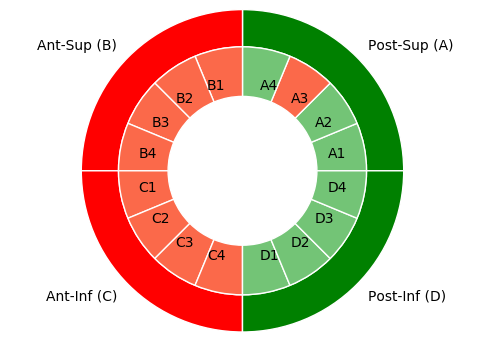

In [568]:
scar_grps = CircularPiePlot(df_data_scalars,4.5)   # use 0.5 for DP and 4.5 for CF

In [530]:
print scar_grps

[-1.       -1.        0.       ...,  0.643777  0.643777  0.643777]


In [531]:
scar_grps.mean()

1.4377485899040467

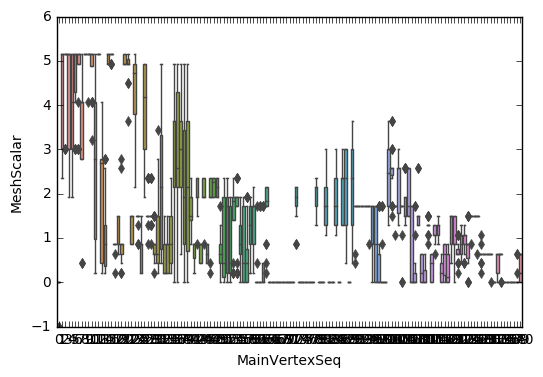

In [465]:
ax = sns.boxplot(x="MainVertexSeq", y="MeshScalar", data=df_data_scalars)

In [466]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

In [467]:
g1.head(2)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar
0,0,10.0,1.0387,27.7952,74.1997,1.0,0.00000
1,1,5186.0,29.3417,47.2292,96.8264,1.0,5.15021


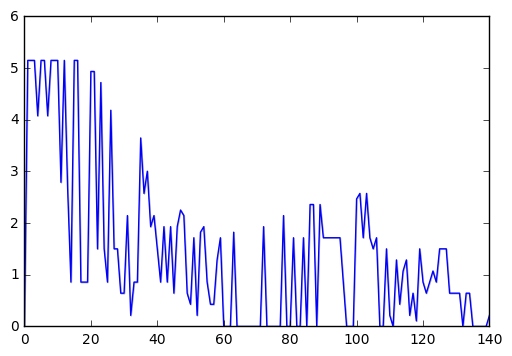

In [468]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [452]:
center_data = [df_data['X'].mean(), df_data['Y'].mean(), df_data['Z'].mean()]

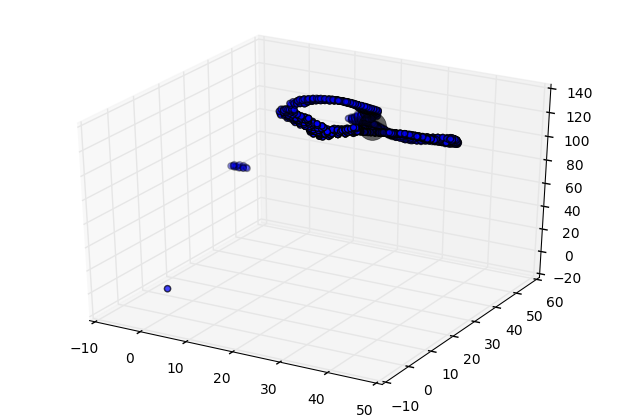

In [421]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_data['X'], df_data['Y'], df_data['Z'])
ax.plot([center_data[0]], [center_data[1]], [center_data[2]], markerfacecolor='k', markeredgecolor='k', marker='o', markersize=20, alpha=0.6)
plt.show()

In [422]:
center_data

[23.878635469461955, 40.23760483938271, 112.05206357947424]

In [423]:
df_data_scalars = pd.concat([df_data['MainVertexSeq'], df_data['MeshScalar']], axis=1)

In [424]:
g1 = df_data.groupby(['MainVertexSeq']).median()
g1 = g1.reset_index()

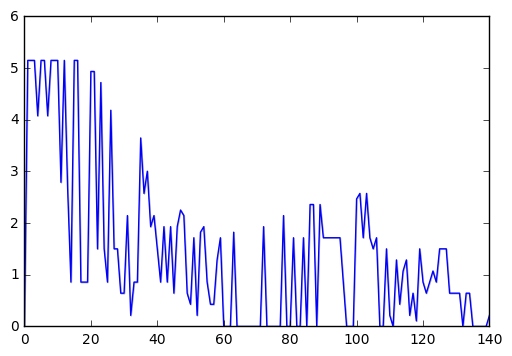

In [425]:
ax = sns.tsplot(data=g1['MeshScalar'])

In [426]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
#    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    return np.arctan2(LA.norm(np.cross(v1_u, v2_u)), np.dot(v1_u, v2_u))
    

In [427]:
def point_theta(center, A):
    thetas = []; 
    Ref_pt = [A.iloc[0]['X'], A.iloc[0]['Y'], A.iloc[0]['Z']] 
    Ref_V = np.subtract(Ref_pt, center)
    for index, row in A.iterrows():
        pt = [row['X'], row['Y'], row['Z']]
        pt_V = np.subtract(pt, center)
        #theta = angle_between(Ref_pt, pt)
        theta = angle_between(Ref_V, pt_V)
        theta = theta * 180 / np.pi
        thetas.append(theta)
    return thetas


In [428]:
thetas = point_theta(center_data, df_data)

In [429]:
thetas_df = pd.Series(thetas, name='theta');

In [430]:
thetas_df.describe()

count    2397.000000
mean       91.962639
std        30.019943
min         0.000000
25%        66.521314
50%        91.930938
75%       106.141855
max       163.511193
Name: theta, dtype: float64

In [106]:
df_data_with_theta = pd.concat([df_data, thetas_df], axis=1)

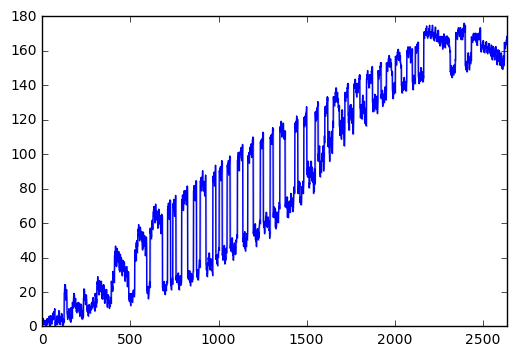

In [107]:
sns.tsplot(df_data_with_theta['theta'])

In [108]:
df_data_with_thetas_sorted = df_data_with_theta.sort_values(by='theta')

In [109]:
df_data_with_thetas_sorted.head(10)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,6708,21.2104,2.88195,-2.67699,0,114.333,0.000000
75,4,6708,21.2104,2.88195,-2.67699,2,114.333,0.000000
116,6,6708,21.2104,2.88195,-2.67699,1,114.333,0.000000
23,1,6708,21.2104,2.88195,-2.67699,1,114.333,0.000000
44,2,6708,21.2104,2.88195,-2.67699,1,114.333,0.000000
1,0,6708,21.2104,2.88195,-2.67699,3,114.333,0.000000
13,0,6944,21.0294,2.89338,-1.79445,2,126.600,1.042498
30,1,6944,21.0294,2.89338,-1.79445,1,126.600,1.042498
117,6,6944,21.0294,2.89338,-1.79445,1,126.600,1.042498
79,4,6944,21.0294,2.89338,-1.79445,1,126.600,1.042498


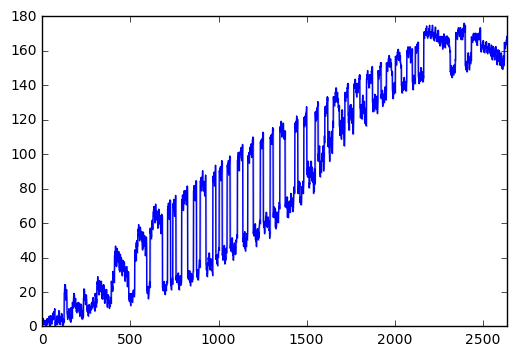

In [144]:
sns.tsplot(df_data_with_thetas_sorted['theta'])

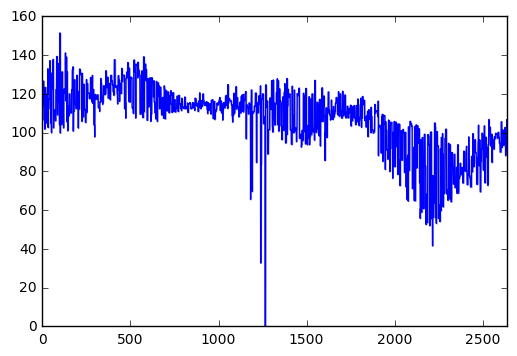

In [111]:
sns.tsplot(df_data_with_thetas_sorted['MeshScalar'])

In [112]:
df_data_with_thetas_sorted.head(15)

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,6708,21.2104,2.88195,-2.67699,0,114.333,0.000000
75,4,6708,21.2104,2.88195,-2.67699,2,114.333,0.000000
116,6,6708,21.2104,2.88195,-2.67699,1,114.333,0.000000
23,1,6708,21.2104,2.88195,-2.67699,1,114.333,0.000000
44,2,6708,21.2104,2.88195,-2.67699,1,114.333,0.000000
1,0,6708,21.2104,2.88195,-2.67699,3,114.333,0.000000
13,0,6944,21.0294,2.89338,-1.79445,2,126.600,1.042498
30,1,6944,21.0294,2.89338,-1.79445,1,126.600,1.042498
117,6,6944,21.0294,2.89338,-1.79445,1,126.600,1.042498
79,4,6944,21.0294,2.89338,-1.79445,1,126.600,1.042498


In [113]:
df_data_with_thetas_sorted['MeshScalar'].std()

17.049944347559176

In [114]:
df_data_with_thetas_sorted.head()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
0,0,6708,21.2104,2.88195,-2.67699,0,114.333,0.0
75,4,6708,21.2104,2.88195,-2.67699,2,114.333,0.0
116,6,6708,21.2104,2.88195,-2.67699,1,114.333,0.0
23,1,6708,21.2104,2.88195,-2.67699,1,114.333,0.0
44,2,6708,21.2104,2.88195,-2.67699,1,114.333,0.0


In [115]:
df_data_with_thetas_sorted_nodupes = df_data_with_thetas_sorted.drop_duplicates(subset='VertexID', keep='last');

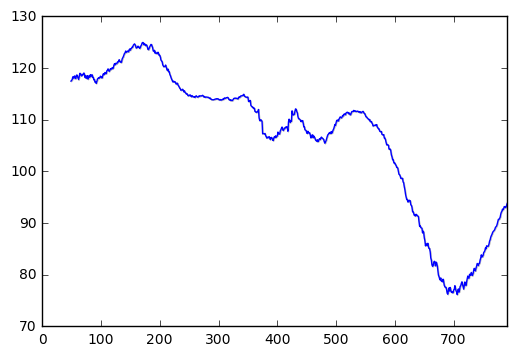

In [136]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted_nodupes['MeshScalar'],50))

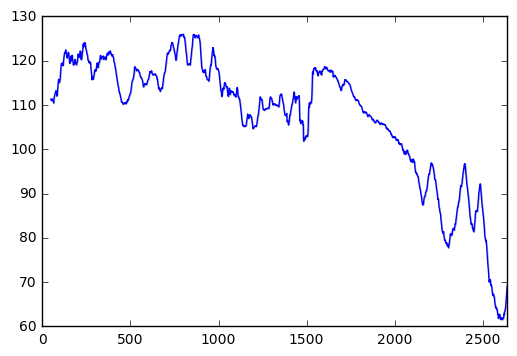

In [142]:
sns.tsplot(pd.rolling_mean(df_data_with_theta['MeshScalar'], 50))

In [117]:
df_data_with_thetas_sorted_nodupes.describe()

,MainVertexSeq,VertexID,X,Y,Z,VertexDepth,MeshScalar,theta
count,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000
mean,77.969697,11828.342172,7.902461,0.305765,15.425807,1.209596,106.672363,89.911084
std,44.910042,3380.052096,10.965187,6.833605,11.769602,0.545302,17.565356,55.778920
min,0.000000,6231.000000,-9.009750,-11.683300,-4.638890,0.000000,0.000000,0.000000
25%,39.000000,8397.750000,-2.419850,-5.918115,3.729693,1.000000,99.321400,37.649230
50%,77.500000,11929.500000,6.777240,0.002981,15.870450,1.000000,110.550000,88.788464
75%,118.000000,15094.250000,18.412825,6.787137,26.514900,1.000000,117.349750,143.999618
max,155.000000,16710.000000,26.851100,10.507000,33.219000,3.000000,151.429000,176.049457


In [118]:
''' 
This function is not complete yet, it tries to compute the distance between each point in the list to its
point on the line (vertex depth = v for all points within the same neighbourhood) 
'''
def scar_width(df, threshold):
    width = []; 
    is_scar = []; 
    #Ref_pt = [A.iloc[0]['X'], A.iloc[0]['Y'], A.iloc[0]['Z']] 
    
    for index, row in df.iterrows():
        if row['VertexDepth'] == 0:
            pt_on_line = (row['X'], row['Y'], row['Z'])
            
        pt = (row['X'], row['Y'], row['Z'])
        #distance = math.hypot(pt[0]-pt_on_line[0], pt[1]-pt_on_line[1], pt[1]-pt_on_line[1])
        distance = math.sqrt((pt[0]-pt_on_line[0])**2 + (pt[1]-pt_on_line[1])**2 + (pt[2]-pt_on_line[2])**2)
        
        
        if row['MeshScalar'] > threshold: 
            is_scar.append(1) 
            width.append(distance)
        else:
            is_scar.append(0)
            width.append(0)
    
    width_df = pd.Series(width, name='scar_width');
    is_scar_df = pd.Series(is_scar, name='scar_bin');
    
    df = pd.concat([df, width_df], axis=1)
    df = pd.concat([df, is_scar_df], axis=1)

    return df

In [119]:
df_data_with_thetas_sorted = scar_width(df_data_with_thetas_sorted, 2.2)

In [120]:
df_data_with_thetas_sorted['MeshScalar'].mean()

107.16420674753574

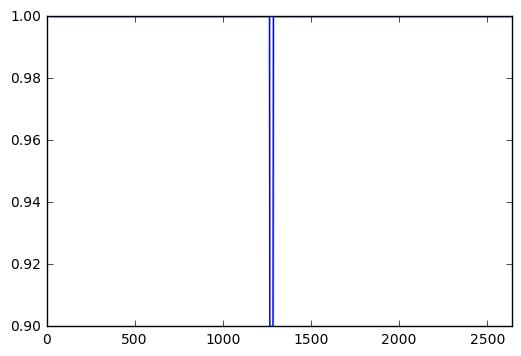

In [121]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted['scar_bin'],20))

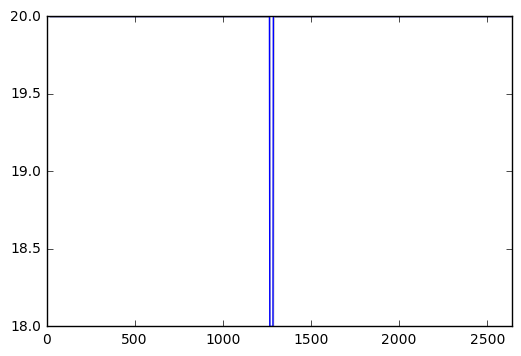

In [122]:
sns.tsplot(pd.rolling_sum(df_data_with_thetas_sorted['scar_bin'],20))

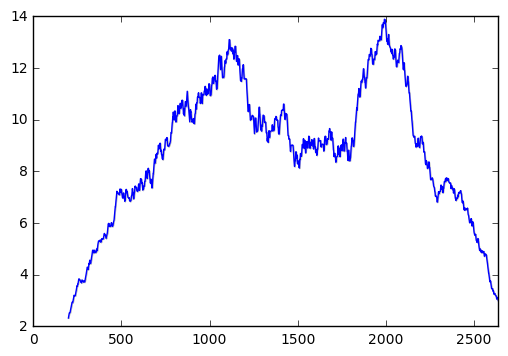

In [123]:
sns.tsplot(pd.rolling_mean(df_data_with_thetas_sorted['scar_width'],200)) # Uses mean windowing=100, so 0 widths are smoothed

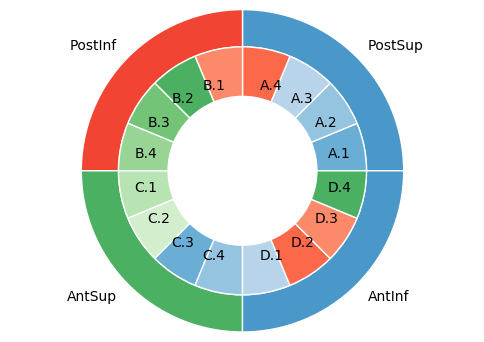

In [232]:
# Libraries
# See https://python-graph-gallery.com/163-donut-plot-with-subgroups/
import matplotlib.pyplot as plt
 
# Make data: I have 3 groups and 7 subgroups
group_names=['PostSup', 'PostInf', 'AntSup', 'AntInf']
group_size=[1,1,1,1]
subgroup_names=['A.1', 'A.2', 'A.3', 'A.4','B.1', 'B.2', 'B.3', 'B.4', 'C.1', 'C.2', 'C.3', 'C.4', 'D.1', 'D.2', 'D.3', 'D.4']
subgroup_size=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
 
# Create colors
a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6), c(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), c(0.6), c(0.5), c(0.4), c(0.3), c(0.2)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.show()


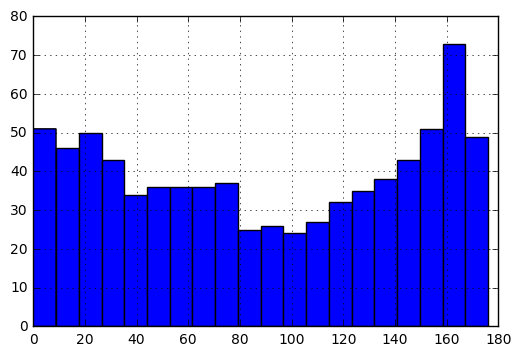

In [125]:
df_data_with_thetas_sorted_nodupes['theta'].hist(bins=20)

In [160]:
test_array = df_data_with_theta.as_matrix(columns=df_data_with_theta.columns[7:8])

In [170]:
test_array.shape


(2638, 1)

In [172]:
2639/12

219

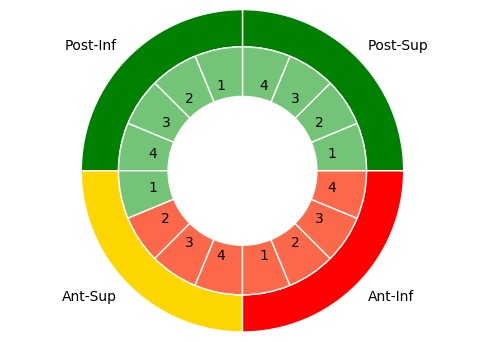

In [359]:
scar_grps

[0, 0, 3, 4]